# This is second notebook => [first notebook with EDA](https://www.kaggle.com/mukeshmanral/eda-diff-model-merchandise-popularity/edit/run/77340531)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machinehack-ml-merchandise-popularity-prediction/MPP_Dataset/sample_submission.csv
/kaggle/input/machinehack-ml-merchandise-popularity-prediction/MPP_Dataset/Train.csv
/kaggle/input/machinehack-ml-merchandise-popularity-prediction/MPP_Dataset/Test.csv


In [2]:
import seaborn as sns
from matplotlib import pylab
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,log_loss
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('../input/machinehack-ml-merchandise-popularity-prediction/MPP_Dataset/Train.csv')
test_df = pd.read_csv('../input/machinehack-ml-merchandise-popularity-prediction/MPP_Dataset/Test.csv')

In [4]:
train_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
0,0.407,0.00380,2,-35.865,1,0.9920,0.944,0.0988,0.1100,113.911,189125,4
1,0.234,0.10500,0,-19.884,1,0.9440,0.900,0.1290,0.0382,76.332,186513,4
2,0.668,0.72600,9,-7.512,1,0.0387,0.000,0.1340,0.4530,124.075,172143,4
3,0.184,0.00561,4,-34.357,1,0.8490,0.931,0.1110,0.0641,79.037,184000,5
4,0.231,0.13100,6,-22.842,1,0.9370,0.000,0.1090,0.0677,109.560,186507,3


In [5]:
test_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time
0,0.164,0.994,1,-23.718,0,0.12400,0.99100,0.7890,0.00001,127.602,236436
1,0.586,0.636,4,-7.710,1,0.00208,0.32200,0.1070,0.35500,136.337,253631
2,0.457,0.743,0,-7.591,1,0.40400,0.00931,0.2010,0.68800,154.902,215669
3,0.423,0.748,5,-9.832,1,0.03000,0.22100,0.1690,0.42800,93.977,325200
4,0.802,0.756,2,-10.791,0,0.08430,0.00765,0.0521,0.96300,131.715,288293


I am not goign to perform EDA again in this notebook if you are intrusted  in deep EDA you can visit my other notebook

# Preprocessing

In [6]:
#convert the time column into more columns like hour, month, day, year , minute
train_df['minute'] = pd.to_datetime(train_df['time'].astype(int),unit='s').dt.minute
train_df['hour'] = pd.to_datetime(train_df['time'].astype(int),unit='s').dt.hour
train_df['day'] = pd.to_datetime(train_df['time'].astype(int),unit='s').dt.day
train_df['month'] = pd.to_datetime(train_df['time'].astype(int),unit='s').dt.month
train_df['year'] = pd.to_datetime(train_df['time'].astype(int),unit='s').dt.year

In [7]:
# drop popularity from train_df and name that variable as y
#drop popularity n time from train dataset
y = train_df.popularity
train_df = train_df.drop(['popularity','time'],1)

# Scaling and Why do it??
* Real time dataset will contain features highly varying in magnitudes, units and range
* Most of the machine learning algorithms use Euclidean distance between two data points in their computations, this is a problem
* If left alone these algorithms only take in magnitude of features neglecting units
* Results would vary greatly between different units, 5kg and 5000gms
* Features with high magnitudes will weigh in a lot more in distance calculations than features with low magnitudes

`To suppress this effect, we need to bring all features to same level of magnitudes and this can be achieved by scaling`

# Min Max Scaling

Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias

To deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.

In [8]:
# Helper function for scaling all the numerical data using MinMaxScalar
def min_max_scaling(data,col_to_scale):
    from numpy import asarray
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    data[col_to_scale] = scaler.fit_transform(data[col_to_scale])
    return data

In [9]:
train_df.head(2)

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,minute,hour,day,month,year
0,0.407,0.0038,2,-35.865,1,0.992,0.944,0.0988,0.1100,113.911,32,4,3,1,1970
1,0.234,0.1050,0,-19.884,1,0.944,0.900,0.1290,0.0382,76.332,48,3,3,1,1970


In [10]:
# Making a list of the column names to be scaled 
col_to_scale = ['Store_Ratio','Basket_Ratio','Category_1','Store_Score','Category_2','Store_Presence','Score_1','Score_2','Score_3','Score_4']

# passing data and column name for scaling
X = min_max_scaling(train_df,col_to_scale)

In [11]:
X.head(2)

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,minute,hour,day,month,year
0,0.407816,0.003585,0.181818,0.246563,1.0,0.995984,0.944,0.088755,0.110110,0.518482,32,4,3,1,1970
1,0.234469,0.104807,0.000000,0.583026,1.0,0.947791,0.900,0.119600,0.038238,0.347436,48,3,3,1,1970


In [12]:
y.head(2)

0    4
1    4
Name: popularity, dtype: int64

# Splitting data into train and test set

In [13]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

In [14]:
# split data into 95% train , 5% test and random state 42
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.95,random_state=42)

# check shape of X_train
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((17297, 15), (911, 15), (17297,), (911,))

# Modelling

In [15]:
# importing necessary libraries for geting metrics of models
import math
import sklearn.metrics as metrics
from sklearn.metrics import median_absolute_error as MedAE,mean_absolute_error as MeanAE,r2_score as r2,accuracy_score,classification_report,confusion_matrix

In [16]:
# Function for calculating all the relevant metrics 
def report_score(model):
    report = classification_report(y_test,model.predict(X_test))
    # one can add more into it 
    print(f'Classification Report\n {report}')

In [17]:
# Helper function for Visualizing importance of all the features in the dataset for the prediction
def feature_imp(feature_importances,feat_train_df):
    # creating dataframe for feature name and feature importance
    feature_imp_df = pd.DataFrame()
    _df = pd.DataFrame()
    _df['feature_imp'] = feature_importances
    _df['column'] = feat_train_df.columns
    feature_imp_df= pd.concat([feature_imp_df,_df],axis=0,ignore_index=True)
    # grouping all data and sorting in descending order
    descend_ordr = feature_imp_df.groupby('column').sum()[['feature_imp']].sort_values('feature_imp',ascending=False).index[:50]
    
    # ploting feature importance data using boxenplot
    # return fig, ax
    fig,ax = plt.subplots(figsize=(8,max(6,len(descend_ordr)*.25)))
    # Visualize importance of all the features in the dataset for the prediction
    sns.boxenplot(data=feature_imp_df,x='feature_imp',y='column',order=descend_ordr,ax=ax,palette='viridis',orient='h')
    ax.tick_params(axis='x',rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig,ax 

# LOGISTIC REGRESSION
One of the most popular Machine Learning algorithms, comes under the Supervised Learning technique

* Logistic Regression is much similar to Linear Regression except that how they are used
    * Linear Regression is used for solving Regression problems whereas 
    * Logistic regression is used for solving the classification problems

In [18]:
'''
%%time
# Fit a logistic Regression model to the train dataset

# Import logisticRegressor
from sklearn.linear_model import LogisticRegression

# Instantiate the model
log_reg = LogisticRegression()
# fitting the model on train data
log_reg.fit(X_train,y_train)
# print score of the model by calling function
report_score(log_reg)
# visualizing importance of features
fig,ax = feature_imp(log_reg.coef_[0],X)'''

'\n%%time\n# Fit a logistic Regression model to the train dataset\n\n# Import logisticRegressor\nfrom sklearn.linear_model import LogisticRegression\n\n# Instantiate the model\nlog_reg = LogisticRegression()\n# fitting the model on train data\nlog_reg.fit(X_train,y_train)\n# print score of the model by calling function\nreport_score(log_reg)\n# visualizing importance of features\nfig,ax = feature_imp(log_reg.coef_[0],X)'

# RANDOM FOREST CLASSIFIER

This algorithm creates decision trees on data samples and then gets prediction from each of them and finally selects best solution by means of voting

* It is an ensemble method which is better than a single decision tree because it reduces over-fitting by averaging result

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.73      0.84        11
           3       0.86      0.32      0.47       115
           4       0.89      0.99      0.94       761
           5       1.00      0.41      0.58        22

    accuracy                           0.89       911
   macro avg       0.95      0.69      0.77       911
weighted avg       0.89      0.89      0.87       911



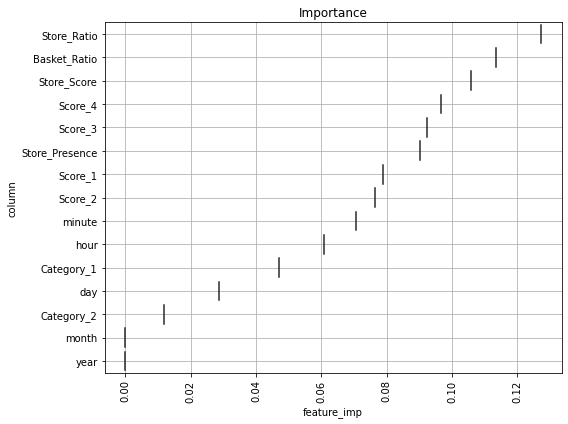

In [19]:
# Fit a RandomForestClassifier model to the train dataset

#import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf_clf = RandomForestClassifier()
# fitting the model on t/rain data
rf_clf.fit(X_train,y_train)
# print score of the model
report_score(rf_clf)
# visualizing importance of features
fig,ax = feature_imp(rf_clf.feature_importances_,X)

# ADA BOOST CLASSIFIER
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on original dataset and then fits additional copies of classifier on same dataset but where weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.09      0.00        11
           3       0.00      0.00      0.00       115
           4       0.70      0.34      0.45       761
           5       0.00      0.00      0.00        22

    accuracy                           0.28       911
   macro avg       0.34      0.29      0.29       911
weighted avg       0.58      0.28      0.38       911



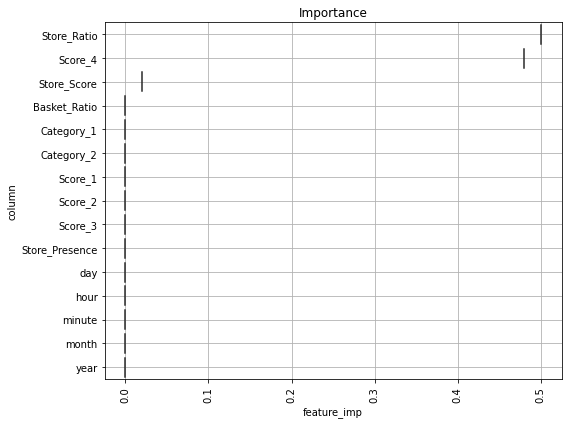

In [20]:
# Fit a AdaBoost classifier model to the train dataset

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
# Instantiate the model
ad_clf = AdaBoostClassifier()
# fitting the model on train data
ad_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(ad_clf)
# visualizing importance of features
fig,ax = feature_imp(ad_clf.feature_importances_,X)

# SUPORT VECTOR CLASSIFIER

It is a Supervised Machine learning model that uses classification algorithms for two-group classification problems

After giving an SVM model sets of labeled training data for each category, they’re able to categorize new text

In [21]:
# Fit a support vector classifier model to the train dataset

#import SVC
from sklearn.svm import SVC
# Instantiate the model
svc = SVC()
#fit the model on train data
svc.fit(X_train,y_train)
# print score of the model by calling function
report_score(svc)

Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           3       0.00      0.00      0.00       115
           4       0.84      1.00      0.91       761
           5       0.00      0.00      0.00        22

    accuracy                           0.84       911
   macro avg       0.17      0.20      0.18       911
weighted avg       0.70      0.84      0.76       911



# DESISION TREE CLASSICIFIER
It is a simple and widely used classification technique 

* It applies a straitforward idea to solve classification problem
* Decision Tree Classifier poses a series of carefully crafted questions about attributes of test record
* Each time time it receive an answer, a follow-up question is asked until a conclusion about calss label of record is reached


Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.31      0.73      0.43        11
           3       0.45      0.41      0.43       115
           4       0.92      0.89      0.91       761
           5       0.27      0.45      0.34        22

    accuracy                           0.82       911
   macro avg       0.59      0.70      0.62       911
weighted avg       0.84      0.82      0.83       911



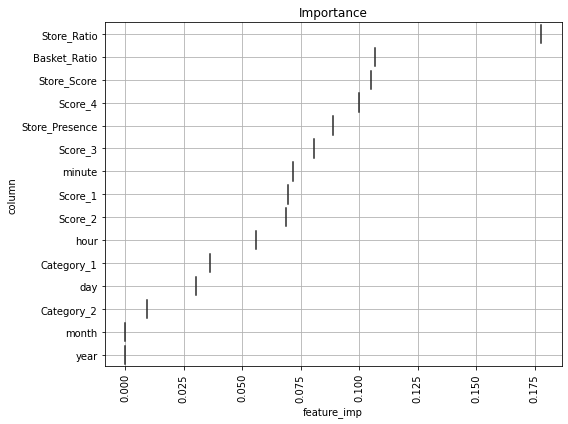

In [22]:
# Fit a DecisionTreeClassifier model to the train dataset

#import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Instantiate the model
dt_clf = DecisionTreeClassifier()
# fitting the model on train data
dt_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(dt_clf)
# visualizing importance of features
fig,ax = feature_imp(dt_clf.feature_importances_,X)

# KNeighborsClassifier

In [23]:
# Fit a K-Neighbour classifier model to the train dataset

# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the model
kn_clf = KNeighborsClassifier()
# fitting the model on train data
kn_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(kn_clf)

Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.12      0.09      0.11        11
           3       0.50      0.24      0.33       115
           4       0.87      0.96      0.91       761
           5       0.50      0.14      0.21        22

    accuracy                           0.84       911
   macro avg       0.40      0.29      0.31       911
weighted avg       0.80      0.84      0.81       911



# GRADIENT BOOSTING CLASSIFIER

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.33      0.09      0.14        11
           3       0.45      0.11      0.18       115
           4       0.86      0.98      0.91       761
           5       0.80      0.18      0.30        22

    accuracy                           0.84       911
   macro avg       0.69      0.47      0.51       911
weighted avg       0.80      0.84      0.80       911

CPU times: user 27.2 s, sys: 90.2 ms, total: 27.3 s
Wall time: 27.2 s


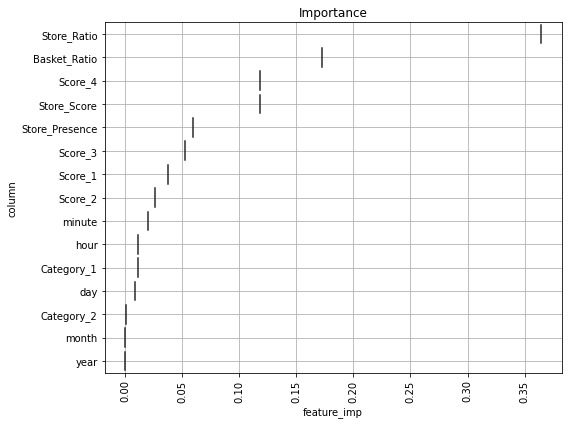

In [24]:
%%time
# Fit a Gradient Boosting Classifier model to the train dataset

# Import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Instantiate the model
gb_clf = GradientBoostingClassifier()
# fitting the model on train data
gb_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(gb_clf)
# visualizing importance of features
fig,ax = feature_imp(gb_clf.feature_importances_,X)

# BAGGING CLASSIFIER

In [25]:
# Fit a Bagging Classifier model to the train dataset

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier
# Instantiate the model
bag_clf = BaggingClassifier()
# fitting the model on train data
bag_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(bag_clf)


Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.73      0.84        11
           3       0.55      0.38      0.45       115
           4       0.90      0.96      0.93       761
           5       0.73      0.36      0.48        22

    accuracy                           0.87       911
   macro avg       0.83      0.69      0.74       911
weighted avg       0.85      0.87      0.85       911



# VOTING CLASSIFIER

In [26]:
# Fit a VotingClassifier model to the train dataset

# Import VotingClassifier
from sklearn.ensemble import VotingClassifier
# list of classifier objects
classifier_lst = [('knn',kn_clf),('svc',svc),('dt',dt_clf),('rf',rf_clf)]
# Instantiate the model
voting_clf = VotingClassifier(estimators=classifier_lst,voting='hard')
# fitting the model on train data
voting_clf.fit(X_train,y_train)
# print score of the model
report_score(voting_clf)

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.89      0.73      0.80        11
           3       0.81      0.30      0.44       115
           4       0.88      0.99      0.93       761
           5       1.00      0.23      0.37        22

    accuracy                           0.88       911
   macro avg       0.92      0.65      0.71       911
weighted avg       0.88      0.88      0.86       911



# EASY ENSEMBLE CLASSIFIER

In [27]:
# Fit a EasyEnsembleClassifier model to the train dataset

# Import EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
# Instantiate the model
easy_clf = EasyEnsembleClassifier()
# fitting the model on train data
easy_clf.fit(X_train,y_train)
# print score of the model
report_score(easy_clf)

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.03      0.36      0.05        11
           3       0.20      0.25      0.22       115
           4       0.94      0.66      0.77       761
           5       0.03      0.14      0.05        22

    accuracy                           0.59       911
   macro avg       0.44      0.48      0.42       911
weighted avg       0.81      0.59      0.68       911



# XGB CLASSIFIER

[07:14:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.88      0.64      0.74        11
           3       0.67      0.25      0.37       115
           4       0.88      0.98      0.93       761
           5       0.70      0.32      0.44        22

    accuracy                           0.87       911
   macro avg       0.83      0.64      0.69       911
weighted avg       0.85      0.87      0.84       911



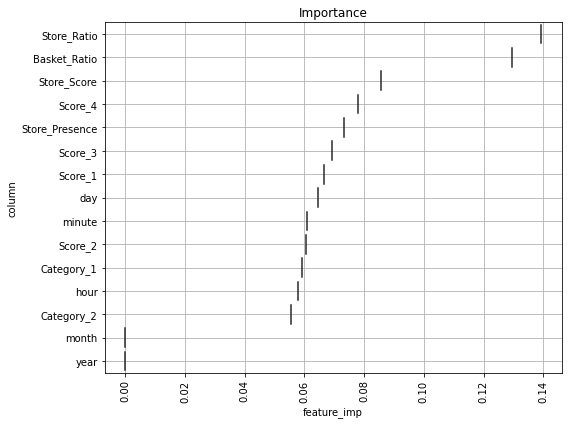

In [28]:
# Fit a XGBClassifier model to the train dataset

# Import XGBClassifier
from xgboost import XGBClassifier
# Instantiate the model
xgb_clf = XGBClassifier()
# fitting the model on train data
xgb_clf.fit(X_train,y_train)
# print score of the model by calling function
report_score(xgb_clf)
# visualizing importance of features
fig,ax = feature_imp(xgb_clf.feature_importances_,X)

# Comparing all model based on metric

In [29]:
# helper function for comparing models matric
def comparing_models_matric(model_list,name_list,X_train,y_train,X_test,y_test):
    # the libraries we need
    import sklearn.metrics as metrics
    from sklearn.model_selection import train_test_split
    
    for(model,name) in zip(model_list,name_list):
        print(f'Model Name: => [** {name} **]')
        # predicting on the test set
        y_pred_test = model.predict(X_test)
        report = classification_report(y_test,y_pred_test)
        print(f'Classification Report: {report}','\n','***'*14,'\n')

In [30]:
# list of model objects
model_list = [rf_clf,ad_clf,svc,dt_clf,kn_clf,gb_clf,bag_clf,voting_clf,easy_clf,xgb_clf]
# list of model names
name_list = ['RF','Ada','SVC','DT','KNN','GBR','Bagging','Voting','Easy','XGB']

# printing comparison of models
comparing_models_matric(model_list,name_list,X_train,y_train,X_test,y_test)

Model Name: => [** RF **]
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.73      0.84        11
           3       0.86      0.32      0.47       115
           4       0.89      0.99      0.94       761
           5       1.00      0.41      0.58        22

    accuracy                           0.89       911
   macro avg       0.95      0.69      0.77       911
weighted avg       0.89      0.89      0.87       911
 
 ****************************************** 

Model Name: => [** Ada **]
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.09      0.00        11
           3       0.00      0.00      0.00       115
           4       0.70      0.34      0.45       761
           5       0.00      0.00      0.00        22

    accuracy                           

# Hyperparameter tuning
A hyperparameter is a parameter whose value is set before the learning process begins

Hyperparameters tuning is crucial as they control the overall behavior of a machine learning model

Every machine learning models will have different hyperparameters that can be set

# Grid Search
One traditional and popular way to perform hyperparameter tuning is by using an Exhaustive Grid Search from Scikit learn.

This method tries every possible combination of each set of hyper-parameters.

Using this method, we can find the best set of values in the parameter search space.

This usually uses more computational power and takes a long time to run since this method needs to try every combination in the grid size.

In [31]:
 # Helper function to perform hyper parameter tunning with GridSearchCV
def gridCV(model,grid):
    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.model_selection import KFold
    from sklearn.model_selection import GridSearchCV
    
    # Grid search of parameters, using 5 fold cross validation
    cv = KFold(n_splits=5,shuffle=False,random_state=None)
    clf = GridSearchCV(model,grid,cv=cv,n_jobs=-1,scoring='f1_macro')
    #fit model_cv
    clf.fit(X_train,y_train)
    # print best parameters
    print(clf.best_params_)
    # print best score
    print(clf.score(X_train,y_train))

**`NOTE`** <br>
One can use hyperparameter values as required this is a kind of framework

In [32]:
'''
# create logistic regressor parameters dict in list for tunning
logi_param_grid = {'C':10.0**np.arange(-2,3),
                  'penalty':['l1','l2']}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(log_reg_model,logi_param_grid) '''

"\n# create logistic regressor parameters dict in list for tunning\nlogi_param_grid = {'C':10.0**np.arange(-2,3),\n                  'penalty':['l1','l2']}\n\n# passing data for hyper parameter tunning with Gridsearchcv\ngridCV(log_reg_model,logi_param_grid) "

In [33]:
# passing data for hyper parameter tunning with Randomized search cv
rf_param_grid = {'n_estimators':[800],
             'max_depth':[5],
             'min_samples_split':[2],
             'min_samples_leaf':[1]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(rf_clf,rf_param_grid)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
0.3822819891033918


In [34]:
# create KNNRegressor parameters dict in list for tunning
knn_param_grid = {'leaf_size':list(range(1,3)),
                 'n_neighbors':list(range(1,3)),
                 'p':[1,2]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(kn_clf,knn_param_grid)

{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
1.0


In [35]:
# create GradientBoostRegressor parameters dict in list for tunning
gb_param_grid = {'n_estimators':[x for x in range(2,5,1)],
             'learning_rate':[0.1],
             'min_samples_split':[x for x in range(2,4)],
             'max_depth':[x for x in range(5,7)]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(gb_clf,gb_param_grid)

{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 4}
0.47451154690140757


In [36]:
# create DecisionTreeRegressor parameters dict in list for tunning
# splitter':['best','random']
# 'max_features':[None,'auto','log2','sqrt']
# 'max_leaf_nodes':[None,20]
dt_param_grid = {'splitter':['best'],
                'max_depth':[1],
                'min_samples_leaf':[1],
                'min_weight_fraction_leaf':[0.1],
                'max_features':['auto'],
                'max_leaf_nodes':[None]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(dt_clf,dt_param_grid)

{'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
0.1822016558063399


In [37]:
# create AdaBoostRegressor parameters dict in list for tunning
# 'n_estimators':[10,50]
# 'learning_rate':[0.001,0.01]
ad_param_grid = {'n_estimators':[10,50],
                'learning_rate':[0.001]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(ad_clf,ad_param_grid)

{'learning_rate': 0.001, 'n_estimators': 10}
0.1822016558063399


# create XGBoost parameters dict in list for tunning
# 'gamma':[0.1,0.2]
# 'max_depth':[1,3]
# 'min_child_weight':[1,3]
# 
xgb_param_grid = {'gamma':[0.1],
                  'max_depth':[1,3],
                  'min_child_weight':[1,3],
                  'colsample_bytree':[0.3],
                  'learning_rate':[0.05]}

# passing data for hyper parameter tunning with Gridsearchcv
gridCV(xgb_clf,xgb_param_grid)

`NOTE:` 
* Any one of RandomizedSearchCv or GridSearchCV can we used, both works fine

# Working on Test Dataset

In [38]:
test_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time
0,0.164,0.994,1,-23.718,0,0.12400,0.99100,0.7890,0.00001,127.602,236436
1,0.586,0.636,4,-7.710,1,0.00208,0.32200,0.1070,0.35500,136.337,253631
2,0.457,0.743,0,-7.591,1,0.40400,0.00931,0.2010,0.68800,154.902,215669
3,0.423,0.748,5,-9.832,1,0.03000,0.22100,0.1690,0.42800,93.977,325200
4,0.802,0.756,2,-10.791,0,0.08430,0.00765,0.0521,0.96300,131.715,288293


# preprocessing time col

In [39]:
# preparing test data as similarly as done for train data before
test_df['minute'] = pd.to_datetime(test_df['time'].astype(int),unit='s').dt.minute
test_df['hour'] = pd.to_datetime(test_df['time'].astype(int),unit='s').dt.hour
test_df['day'] = pd.to_datetime(test_df['time'].astype(int),unit='s').dt.day
test_df['month'] = pd.to_datetime(test_df['time'].astype(int),unit='s').dt.month
test_df['year'] = pd.to_datetime(test_df['time'].astype(int),unit='s').dt.year

test_df = test_df.drop(['time'],axis=1)

In [40]:
# passing test data for scaling
# list of the column names to be scaled 
col_to_scale = ['Store_Ratio','Basket_Ratio','Category_1','Store_Score','Category_2','Store_Presence','Score_1','Score_2','Score_3','Score_4']

# passing data and column name for scaling
Xtest = min_max_scaling(test_df,col_to_scale)

In [41]:
# performing the prediction on the test dataset
y_pred = voting_clf.predict(Xtest)
y_pred

array([4, 4, 4, ..., 4, 4, 4])

In [42]:
# creating a dataframe of predicted results 
predictions = pd.DataFrame(y_pred)

In [43]:
# predicted values in dataframe
predictions.head(10)

,0
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4


# `CONCLUSION`
In my [first notebook]() i did covered EDA, preprocessing, build different models, visualized feature importance, did hyper parameter tunning of each model and did prediction. store ratio is most important column in the dataset. I used voting classifier for prediction